E:\aconda\aconda\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


1) Test RMSE:0.584
2) Test RMSE:0.201
3) Test RMSE:1.318
4) Test RMSE:0.187
5) Test RMSE:0.193
           rmse
count  5.000000
mean   0.496729
std    0.489442
min    0.186804
25%    0.192951
50%    0.201467
75%    0.584066
max    1.318356


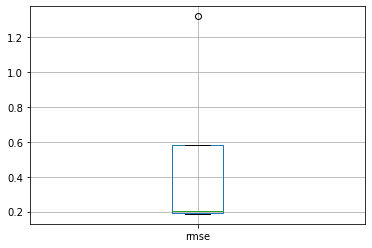

Time used: 1025.5571538


E:\aconda\aconda\lib\site-packages\ipykernel_launcher.py:150: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [6]:
# %load 更健壮的LSTM案例.py
from pandas import read_csv
from pandas import datetime
from pandas import concat
from pandas import DataFrame
from pandas import Series
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import time
import pandas as pd
start = time.clock()


# 读取时间数据的格式化
#def parser(x):
    #return datetime.strptime(x, '%Y/%m/%d')


# 转换成有监督数据
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]  # 数据滑动一格，作为input，df原数据为output
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df


# 转换成差分数据
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)


# 逆差分
def inverse_difference(history, yhat, interval=1):  # 历史数据，预测数据，差分间隔
    return yhat + history[-interval]


# 缩放
def scale(train, test):
    # 根据训练数据建立缩放器
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # 转换train data
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # 转换test data
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled


# 逆缩放
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit LSTM来训练数据
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    # 添加LSTM层
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))  # 输出层1个node
    # 编译，损失函数mse+优化算法adam
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        # 按照batch_size，一次读取batch_size个数据
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
        #print("当前计算次数："+str(i))
    return model


# 1步长预测
def forcast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0, 0]


# 加载数据
series = pd.read_excel(r'C:\Users\stu\Desktop\RDATA.xlsx')
# 让数据变成稳定的
raw_values = (series.values)[0:2000,3]
diff_values = difference(raw_values, 1)#转换成差分数据

# 把稳定的数据变成有监督数据
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# 数据拆分：训练数据、测试数据，前24行是训练集，后12行是测试集
train, test = supervised_values[0:-50], supervised_values[-50:]

# 数据缩放
scaler, train_scaled, test_scaled = scale(train, test)



#重复实验   
repeats = 5


error_scores = list()
for r in range(repeats):
    # fit 模型
    lstm_model = fit_lstm(train_scaled, 1, 100, 40)  # 训练数据，batch_size，epoche次数, 神经元个数
    # 预测
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)#训练数据集转换为可输入的矩阵
    lstm_model.predict(train_reshaped, batch_size=1)#用模型对训练数据矩阵进行预测
    # 测试数据的前向验证，实验发现，如果训练次数很少的话，模型回简单的把数据后移，以昨天的数据作为今天的预测值，当训练次数足够多的时候
    # 才会体现出来训练结果
    predictions = list()
    for i in range(len(test_scaled)):
        # 1步长预测
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forcast_lstm(lstm_model, 1, X)
        # 逆缩放
        yhat = invert_scale(scaler, X, yhat)
        # 逆差分
        yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 1 - i)
        predictions.append(yhat)
        expected = raw_values[len(train) + i + 1]
        #print('Moth=%d, Predicted=%f, Expected=%f' % (i + 1, yhat, expected))
    # 性能报告
    rmse = sqrt(mean_squared_error(raw_values[-50:], predictions))
    print('%d) Test RMSE:%.3f' %(r+1,rmse))
    error_scores.append(rmse)

#统计信息   
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()
elapsed = (time.clock() - start)
print("Time used:",elapsed)

In [7]:
zs=raw_values[-50:]
yuce=predictions
error = []
for i in range(len(zs)):
    error.append(zs[i] -yuce[i])
#print("Errors: ", error)
#print(error)
squaredError = []
absError = []
for val in error:    
    squaredError.append(val * val)#target-prediction之差平方     
    absError.append(abs(val))#误差绝对值  
   # print("Square Error: ", squaredError)
    #print("Absolute Value of Error: ", absError)    
print("MSE = ", sum(squaredError) / len(squaredError))#均方误差MSE    
from math import sqrt
print("RMSE = ", sqrt(sum(squaredError) / len(squaredError)))#均方根误差RMSE
print("MAE = ", sum(absError) / len(absError))#平均绝对误差MAE

MSE =  0.03723002371830148
RMSE =  0.19295083238561445
MAE =  0.14502160796499425


In [8]:
import openpyxl as op
wb=op.load_workbook(r'C:\Users\stu\Desktop\lstm.xlsx')
print(wb.sheetnames)
ws=wb['Sheet1']
#yuce=yuce.tolist()
#escape(yuce).encode('utf-8')
for index,rw in enumerate(yuce):        
        ws.cell(row = index+1, column =4).value = rw
wb.save(r'C:\Users\stu\Desktop\lstm.xlsx')

['Sheet1']


In [8]:
10.632382**2



113.047546993924

In [9]:
import pandas as pd
se1 = pd.read_excel(r'C:\Users\stu\Desktop\RDATA.xlsx').values
se2 = pd.read_excel(r'C:\Users\stu\Desktop\result.xlsx',sheet_name='Sheet1').values
zs=se1[:,3][-50:]
yuce=se2[:,3]
error = []
for i in range(len(zs)):
    error.append(zs[i] -yuce[i])
#print("Errors: ", error)
#print(error)
squaredError = []
absError = []
for val in error:    
    squaredError.append(val * val)#target-prediction之差平方     
    absError.append(abs(val))#误差绝对值  
   # print("Square Error: ", squaredError)
    #print("Absolute Value of Error: ", absError)    
print("MSE = ", sum(squaredError) / len(squaredError))#均方误差MSE    
from math import sqrt
print("RMSE = ", sqrt(sum(squaredError) / len(squaredError)))#均方根误差RMSE
print("MAE = ", sum(absError) / len(absError))#平均绝对误差MAE

MSE =  0.016662275354200572
RMSE =  0.1290824362731064
MAE =  0.10632247630977046
